# Améliorez le produit IA de votre start-up

In [1]:
### basic libs
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import warnings
# api
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
# text 
from nltk.stem.snowball import EnglishStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# image
import tensorflow as tf
from sklearn.manifold import TSNE

warnings.simplefilter(action='ignore', category=FutureWarning)

pyLDAvis.enable_notebook()

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

debug = 1


c:\users\skrell\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
c:\users\skrell\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
c:\users\skrell\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated ali

### API queries

In [2]:
with open("api.key", "r") as f:
    api_key = f.readline()


header = {'Authorization': f'bearer {api_key}',
         'Content-Type': 'application/json'}

# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(url="https://api.yelp.com/v3/graphql", headers=header, use_json=True)

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)


In [3]:
def get_new_reviews(city):

    df_reviews = pd.DataFrame(columns=['text', 'rating'])
    
    offset = 50
    
    for chunk in range(4):
        query = '''
        {
          search(term:"restaurants",
                 limit : 50,
                 offset: '''+str(offset*chunk)+''',
                 location:"''' + city + '''") {
            business {
              reviews {
                text
                rating
              }
            }
          }
        }
        '''
        query = gql(query)
        result = client.execute(query)
    
        for business in result["search"]["business"]:
            for review in business["reviews"]:
                df_reviews = df_reviews.append(review, ignore_index=True)
                
    df_reviews = df_reviews.dropna()

    df_reviews.to_csv('new_reviews.csv')
    
    print(f"Got {df_reviews.shape[0]} reviews")
    
    print(df_reviews.head())
    
# get_new_reviews("san francisco")

### Comments analysis

In [4]:
if debug:
    nrows = 1000
else:
    nrows = None

filename = './preprocessed_reviews.csv'

comments = pd.read_csv(filename, nrows=nrows)

comments.head()

,tokenized_text
0,marriott renaiss marriott huge desk atrium sta...
1,cool chill bunch neanderth bouncer hop steroid...
2,set perfect adequ dine chain chili victoria st...
3,correct crappi inconsist gone hill steadili 9
4,bolt follow fanni fabric fanni select fabric l...


In [5]:
def plot_hist_stats(df, feature, title=None, verticale=False):
    """Affiche l'histogramme d'une caractéristique"""
    tmp = df[feature].value_counts()
    df_tmp = pd.DataFrame({ 
                            feature: tmp.index,
                            'Quantity': tmp.values
                          })

    fig, ax = plt.subplots(figsize=(15,6))
    sns.set_color_codes("pastel")

    s = sns.barplot(ax = ax,
                    x = feature,
                    y = 'Quantity',
                    data = df_tmp)
   
    if title != None:
        plt.title(title)

    if verticale == True:
        plt.xticks(rotation=90)

    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();
    
def plot_coherence_values(df_coherence):
        """
        plot c_v coherence for various number of topics
        """
        fig, ax = plt.subplots(figsize=(12,6))
        sns.set_color_codes("pastel")
    
        s = sns.lineplot(ax = ax, x = 'nb_of_topics', y = 'coherence_value', data = df_coherence)
        plt.title('Coherence score evolution with number of topics')
        plt.show()
        
def dist_plot_nb_characters_and_words():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    sns.set_style('darkgrid')

    list_nb_characters = [len(x) for x in comments["tokenized_text"]]
    list_nb_of_words = [len(x.split()) for x in comments["tokenized_text"]]

    ax1.set_title('number of characters per clean review distribution')
    sns.histplot(list_nb_characters, ax = ax1)

    ax2.set_title('number of words per clean review distribution')
    sns.histplot(list_nb_of_words, ax = ax2)

    plt.show()

def plot_freqDist():
    ## Creating FreqDist,keeping the 30 most common tokens
    fdist_sw = FreqDist(list_list_to_list(comments["tokenized_text"].to_list())).most_common(30)

    df_fdist_sw = pd.Series(dict(fdist_sw))

    sns.barplot(x=df_fdist_sw.values, y=df_fdist_sw.index, ax=ax1)
    plt.set_title('Most commons words in tokenized text')

    plt.show()

In [6]:
models_best_coherence_score = {}

comments["tokenized_text"] = comments["tokenized_text"].apply(lambda x: x.split())

def list_list_to_list(x):
    return [item for sublist in x for item in sublist]

def clean_data_rdy(data_ready_for_model):
    dictionary = gensim.corpora.Dictionary(data_ready_for_model)
    count = 0

    for k, v in dictionary.iteritems():
        count += 1
        if count > 10:
            break

    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary

    
def LDA_TF_IDF(start, limit):
    # Create Dictionary
    id2word = clean_data_rdy(comments["tokenized_text"])

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments["tokenized_text"]]

    tfidf = gensim.models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    coherence = []
    for k in list(range(start, limit, 1)):         
        ldamodel_tf_idf = gensim.models.LdaMulticore(corpus_tfidf,
                                                     num_topics=k,
                                                     id2word = id2word,
                                                     iterations=200,
                                                     passes=2,
                                                     workers=4)

        cm = gensim.models.coherencemodel.CoherenceModel(model = ldamodel_tf_idf, 
                                                         texts = comments["tokenized_text"],
                                                         dictionary = id2word,
                                                         coherence='c_v')

        coherence.append((k,cm.get_coherence()))

    #Create dataframe with coherence value for each number of topic
    df_coherence = pd.DataFrame(coherence, columns=['nb_of_topics', 'coherence_value'])

    #Select best number of topic
    best_num_topic = df_coherence['nb_of_topics'][df_coherence['coherence_value'].idxmax()]
    models_best_coherence_score['LDA_TF_IDF'] = df_coherence['coherence_value'].max()

    #Plot
    plot_coherence_values(df_coherence)

    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                                 num_topics=best_num_topic,
                                                 id2word=id2word,
                                                 iterations=200,
                                                 passes=2,
                                                 workers=4)
    #visualization
    visualisation = gensimvis.prepare(lda_model_tfidf, corpus, id2word)

    return lda_model_tfidf, visualisation
    
        
def LDA(start, limit):
    """
    Compute c_v coherence for various number of topics
    """        
    # Create Dictionary
    id2word = clean_data_rdy(comments["tokenized_text"])

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments["tokenized_text"]]

    coherence = []
    for k in list(range(start, limit, 1)):
        Lda = gensim.models.ldamodel.LdaModel

        ldamodel = Lda( corpus,
                        num_topics=k,
                        id2word = id2word,
                        iterations=200)

        cm = gensim.models.coherencemodel.CoherenceModel(model = ldamodel, 
                                                         texts = comments["tokenized_text"],
                                                         dictionary = id2word,
                                                         coherence='c_v')

        coherence.append((k,cm.get_coherence()))

    #Create dataframe with coherence value for each number of topic
    df_coherence = pd.DataFrame(coherence, columns=['nb_of_topics', 'coherence_value'])

    #Select best number of topic
    best_num_topic = df_coherence['nb_of_topics'][df_coherence['coherence_value'].idxmax()]
    models_best_coherence_score['LDA'] = df_coherence['coherence_value'].max()

    #Plot
    plot_coherence_values(df_coherence)


    #Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                                id2word = id2word,
                                                num_topics = best_num_topic,
                                                iterations=200)

    #visualization
    visualisation = gensimvis.prepare(lda_model, corpus, id2word)

    return lda_model, visualisation


In [7]:
def lda_coherency():

    LDA_model, lda_visu = LDA(4,11)

    for idx, topic in LDA_model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
    return LDA_model, lda_visu
        
# LDA_model, lda_visu = lda_coherency()

In [8]:
# lda_visu

In [9]:
def tf_idf_lda_coherency():
    TF_IDF_LDA_model, lda_tf_idf_visu = LDA_TF_IDF(4, 11)

    for idx, topic in TF_IDF_LDA_model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
    return TF_IDF_LDA_model, lda_tf_idf_visu
        
# TF_IDF_LDA_model, lda_tf_idf_visu = tf_idf_lda_coherency()

In [10]:
# lda_tf_idf_visu

### Picture analysis

In [11]:
nrows = 131072

n_epochs = 20

test_nrows = 2048

val_nrows = 2048

batch_size = 16

steps_per_epoch = nrows // batch_size

AUTOTUNE = tf.data.AUTOTUNE

In [12]:
test_size = 16384

val_size = 2048

BUFFER_SIZE = 1000

def get_path(name):
    return os.path.join("preprocessed_imgs", f"{name}.jpg")

def train_test_img_split():
    pictures = pd.read_json("photos.json", lines=True)[["photo_id", "label"]]
    pictures["path"] = pictures["photo_id"].apply(get_path)
    pictures = pictures[["path", "label"]]
    pictures = pictures.sample(frac=1) # shuffle
    pictures["label"] = pictures["label"].apply(lambda x:  {'interior': 0, 'outside': 1, 'menu': 2, 'food': 3, 'drink': 4}[x])
    test_df = pictures.head(test_size)
    pictures = pictures.tail(pictures.shape[0] - test_size)
    val_df = pictures.head(val_size)
    pictures = pictures.tail(pictures.shape[0] - val_size)
    test_df.to_csv('photos_test.csv', index=False)
    val_df.to_csv('photos_val.csv', index=False)
    pictures.to_csv('photos_train.csv', index=False)
    
def load_img(path, tgt):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    tgt = tf.reshape(tgt, [1])
    return img, tgt

def set_shapes(image, label):
    image.set_shape((224, 224, 3))
    return image, label

# train_test_img_split()

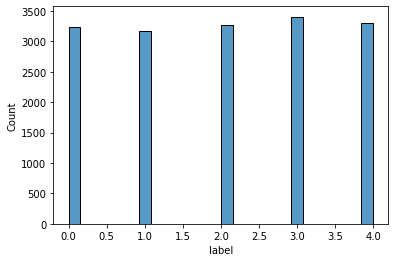

,path,label
41627,preprocessed_imgs\Zjo8VAtPV87qHmGBxyP5xA.jpg,1
75233,preprocessed_imgs\SuUwcZFtcbQDeGR3aMH3bQ.jpg,1
133964,preprocessed_imgs\PcLTOeNn6ye3uz-EjmExpA.jpg,1
29643,preprocessed_imgs\m6HxT2DoEJZYLzFAiIQLtw.jpg,0
58392,preprocessed_imgs\WOJ9EAn1LugLNwgO7uU5YA.jpg,4


In [13]:
train_df = pd.read_csv('photos_train.csv')
train_df = train_df.sample(frac=1)
train_df = train_df.head(nrows)
test_df = pd.read_csv('photos_test.csv')
test_df = test_df.head(test_nrows)
val_df = pd.read_csv('photos_val.csv')
val_df = val_df.head(val_nrows)
sns.histplot(x=train_df["label"])
plt.show()
train_df.head()

In [14]:
def display_learning_curves(hst):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
def tsne(mdl):
    target = [*map(lambda x:int(x[0]), list(np.concatenate([y for x, y in test_ds], axis=0)))]
    model_2 = tf.keras.models.Sequential(mdl.layers[:-3])
    res = model_2.predict(test_ds)
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
    tsne_results = tsne.fit_transform(res)
    plt.scatter(tsne_results[:,0],tsne_results[:,1],  c=target, 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
    plt.colorbar()
    plt.title('TSNE Scatter Plot')
    plt.show()

#### Transfer learning avec VGG16

In [15]:
# make tf dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df["path"].values, tf.cast(train_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["path"].values, tf.cast(test_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df["path"].values, tf.cast(val_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
# load imgs from path
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_img, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_img, num_parallel_calls=AUTOTUNE)
# set imgs shape
train_ds = train_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
# preprocess datasets
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
previously_trained = 0

layer_freeze = 17 # 19

if previously_trained:
    model = tf.keras.models.load_model('vgg16_retrained')
    history = pd.read_csv('train_history.csv')
else:
    vgg_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = vgg_model.output
    x = tf.keras.layers.Flatten()(x)
    predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions) 
    for layer in model.layers[:layer_freeze]:
        layer.trainable = False
    for layer in model.layers[layer_freeze:]:
        layer.trainable = True
        
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
def train_model():
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    hist = model.fit(train_ds, batch_size=batch_size, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, verbose=2)
    hist_df = pd.DataFrame(data=hist.history)
    hist_df.to_csv('train_history.csv', index=False)
    model.save('vgg16_retrained')
    
    return hist_df

history = train_model()

Epoch 1/5
1024/1024 - 180s - loss: 0.6701 - accuracy: 0.7425 - val_loss: 0.5211 - val_accuracy: 0.8086
Epoch 2/5
1024/1024 - 95s - loss: 0.4679 - accuracy: 0.8264 - val_loss: 0.4483 - val_accuracy: 0.8457
Epoch 3/5
1024/1024 - 95s - loss: 0.4120 - accuracy: 0.8516 - val_loss: 0.4642 - val_accuracy: 0.8193
Epoch 4/5
1024/1024 - 96s - loss: 0.3716 - accuracy: 0.8642 - val_loss: 0.4254 - val_accuracy: 0.8379
Epoch 5/5
1024/1024 - 97s - loss: 0.3425 - accuracy: 0.8759 - val_loss: 0.4204 - val_accuracy: 0.8350
INFO:tensorflow:Assets written to: vgg16_retrained\assets


64/64 [==============================] - 5s 81ms/step - loss: 0.4169 - accuracy: 0.8330


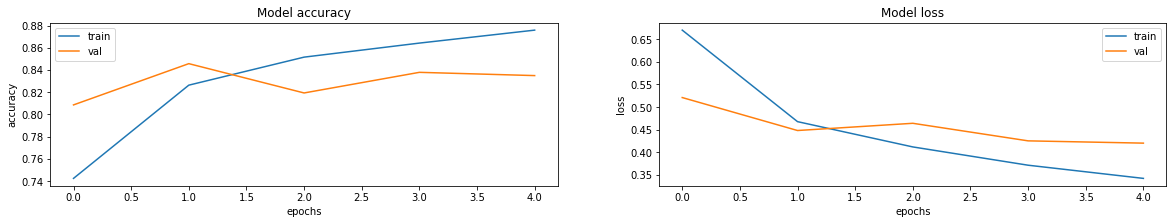

In [18]:
performance = model.evaluate(test_ds)
display_learning_curves(history)

#### Création d'un CNN

In [19]:
already_trained = False

if already_trained:
    cnn = tf.keras.models.load_model('custom_cnn')
    cnn_history = pd.read_csv('train_history.csv')
else:
    cnn = tf.keras.models.Sequential()
    
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Dropout(0.25))
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Dropout(0.25))
    cnn.add(tf.keras.layers.Flatten())
    # cnn.add(tf.keras.layers.Dense(64, activation='relu'))
    # cnn.add(tf.keras.layers.Dropout(0.5))
    cnn.add(tf.keras.layers.Dense(5, activation='softmax'))

print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

In [20]:
def train_cnn():
    cnn.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6), metrics=["accuracy"])
    hist = cnn.fit(train_ds, batch_size=batch_size, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, verbose=2)
    hist_df = pd.DataFrame(data=hist.history)
    hist_df.to_csv('cnn_train_history.csv', index=False)
    cnn.save('custom_cnn')
    
    return hist_df

cnn_history = train_cnn()

Epoch 1/5
1024/1024 - 69s - loss: 1.2260 - accuracy: 0.5104 - val_loss: 1.1057 - val_accuracy: 0.6035
Epoch 2/5
1024/1024 - 67s - loss: 0.9573 - accuracy: 0.6436 - val_loss: 0.9457 - val_accuracy: 0.6582
Epoch 3/5
1024/1024 - 67s - loss: 0.7944 - accuracy: 0.7041 - val_loss: 0.8610 - val_accuracy: 0.6768
Epoch 4/5
1024/1024 - 67s - loss: 0.6826 - accuracy: 0.7552 - val_loss: 0.8259 - val_accuracy: 0.6816
Epoch 5/5
1024/1024 - 66s - loss: 0.5885 - accuracy: 0.7863 - val_loss: 0.8516 - val_accuracy: 0.6885
INFO:tensorflow:Assets written to: custom_cnn\assets


64/64 [==============================] - 1s 18ms/step - loss: 0.8377 - accuracy: 0.6953


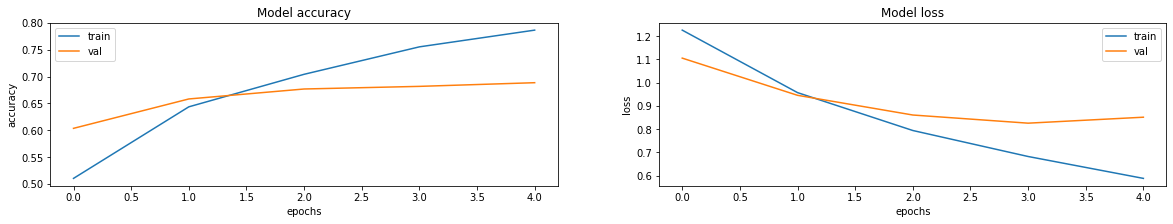

In [21]:
cnn_performance = cnn.evaluate(test_ds)
display_learning_curves(cnn_history)